# Real Time Adjustment

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

from constants import *
from real_time_adj_original import *
from evaluation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [7]:
(prices_B, prices_S, prices_F, prices_forecast, features, features_red, realized, price_H, max_elec, nominal_wind,
 penalty, min_production, forecast_production) = import_consts()

idx_start = len(prices_F) - HOURS_PER_YEAR
idx_end = len(prices_F)

In [13]:
df = pd.read_csv('./results/2020/deterministic.csv')
df.index = pd.date_range(start='1/1/2021', periods=8760, freq='h')
df = df[(df.index >= '2021-01-01 00:00:00') & (df.index <= '2021-01-30 23:00:00')]
display(df)

prices = pd.read_csv('./data/2020_data.csv', index_col=0)
prices.index = pd.date_range(start='1/1/2020', periods=17520, freq='h')
prices = prices[['forward_RE', 'UP', 'DW', 'production_RE']]
prices['production_RE'] *= nominal_wind
# Ensure that the prices are non-negative
prices['forward_RE'] = prices['forward_RE'].clip(lower=0)
prices['UP'] = prices['UP'].clip(lower=0)
prices['DW'] = prices['DW'].clip(lower=0)
prices = prices[(prices.index >= '2021-01-01 00:00:00') & (prices.index <= '2021-01-30 23:00:00')]
display(prices)

forecasts = pd.read_csv('../Wind production forecasts/rolling_forecasts_01_2021.csv', index_col=0)
forecasts.index = pd.date_range(start='1/1/2021', periods=720, freq='h')
forecasts = nominal_wind * forecasts
forecasts = forecasts.clip(lower=0)

display(forecasts)

,forward bid,hydrogen production
2021-01-01 00:00:00,6.735217,0.0
2021-01-01 01:00:00,-7.229688,10.0
2021-01-01 02:00:00,-3.560665,10.0
2021-01-01 03:00:00,5.994885,0.0
2021-01-01 04:00:00,-1.089615,10.0
...,...,...
2021-01-30 19:00:00,-1.612456,10.0
2021-01-30 20:00:00,0.000000,10.0
2021-01-30 21:00:00,0.000000,10.0
2021-01-30 22:00:00,0.000000,10.0


,forward_RE,UP,DW,production_RE
2021-01-01 00:00:00,30.78,30.78,20.00,3.235294
2021-01-01 01:00:00,30.64,30.64,20.00,1.911765
2021-01-01 02:00:00,30.43,30.43,20.00,1.568627
2021-01-01 03:00:00,28.79,28.79,23.00,2.745098
2021-01-01 04:00:00,28.42,28.42,22.73,2.892157
...,...,...,...,...
2021-01-30 19:00:00,19.58,20.67,19.58,9.509804
2021-01-30 20:00:00,19.09,19.09,19.09,9.558824
2021-01-30 21:00:00,18.71,18.71,18.71,8.382353
2021-01-30 22:00:00,18.30,18.30,18.30,6.666667


,FC_1h,FC_2h,FC_3h,FC_4h,FC_5h,FC_6h,FC_7h,FC_8h,FC_9h,FC_10h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-01 00:00:00,2.992904,2.296337,1.930483,2.292906,1.843614,2.187393,3.050414,3.165369,3.398568,2.110845,...,2.394894,6.187304,3.527442,5.343550,5.862827,8.086749,8.542651,8.182789,9.177086,9.165245
2021-01-01 01:00:00,2.423068,1.988212,2.339120,1.876458,2.207819,3.063844,3.174449,3.404569,2.114798,1.938750,...,6.187638,3.527663,5.343697,5.862924,8.086813,8.542694,8.182818,9.177105,9.165257,9.199129
2021-01-01 02:00:00,1.720883,2.217345,1.778974,2.138537,3.020757,3.146118,3.385417,2.102139,1.930410,1.731124,...,3.526957,5.343229,5.862615,8.086608,8.542558,8.182728,9.177046,9.165218,9.199103,9.654737
2021-01-01 03:00:00,2.137740,1.742712,2.109509,3.000126,3.133288,3.376981,2.096436,1.926640,1.728641,2.956400,...,5.343019,5.862475,8.086516,8.542497,8.182687,9.177019,9.165200,9.199091,9.654729,9.481359
2021-01-01 04:00:00,2.060262,2.254160,3.115924,3.215586,3.428162,2.130088,1.949391,1.743678,2.966306,1.435699,...,5.863314,8.087071,8.542865,8.182931,9.177180,9.165307,9.199162,9.654776,9.481390,9.787416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-30 19:00:00,9.041430,8.518451,8.871527,6.679837,7.029696,7.069430,8.652930,9.185578,9.647634,9.663003,...,7.669414,8.606327,8.183193,7.515521,6.995691,6.044070,7.355496,8.788237,9.461627,9.520010
2021-01-30 20:00:00,8.763335,8.983077,6.769136,7.093161,7.108899,8.678882,9.203122,9.659231,9.670643,6.835127,...,8.606974,8.183621,7.515804,6.995879,6.044195,7.355579,8.788292,9.461663,9.520034,9.805577
2021-01-30 21:00:00,9.398989,6.958594,7.244828,7.216688,8.745917,9.247199,9.689028,9.690338,6.848101,8.441108,...,8.184720,7.516532,6.996361,6.044514,7.355790,8.788432,9.461755,9.520095,9.805617,9.939807
2021-01-30 22:00:00,6.427058,7.002700,7.022858,8.608162,9.161528,9.632699,9.652256,6.822931,8.424527,9.269496,...,7.515128,6.995431,6.043898,7.355382,8.788162,9.461577,9.519976,9.805539,9.939755,10.002839


In [14]:
data = pd.concat([df, prices, forecasts], axis=1)
data = data.rename({'production_RE': 'FC_0h'}, axis=1)
display(data)

,forward bid,hydrogen production,forward_RE,UP,DW,FC_0h,FC_1h,FC_2h,FC_3h,FC_4h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-01 00:00:00,6.735217,0.0,30.78,30.78,20.00,3.235294,2.992904,2.296337,1.930483,2.292906,...,2.394894,6.187304,3.527442,5.343550,5.862827,8.086749,8.542651,8.182789,9.177086,9.165245
2021-01-01 01:00:00,-7.229688,10.0,30.64,30.64,20.00,1.911765,2.423068,1.988212,2.339120,1.876458,...,6.187638,3.527663,5.343697,5.862924,8.086813,8.542694,8.182818,9.177105,9.165257,9.199129
2021-01-01 02:00:00,-3.560665,10.0,30.43,30.43,20.00,1.568627,1.720883,2.217345,1.778974,2.138537,...,3.526957,5.343229,5.862615,8.086608,8.542558,8.182728,9.177046,9.165218,9.199103,9.654737
2021-01-01 03:00:00,5.994885,0.0,28.79,28.79,23.00,2.745098,2.137740,1.742712,2.109509,3.000126,...,5.343019,5.862475,8.086516,8.542497,8.182687,9.177019,9.165200,9.199091,9.654729,9.481359
2021-01-01 04:00:00,-1.089615,10.0,28.42,28.42,22.73,2.892157,2.060262,2.254160,3.115924,3.215586,...,5.863314,8.087071,8.542865,8.182931,9.177180,9.165307,9.199162,9.654776,9.481390,9.787416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-30 19:00:00,-1.612456,10.0,19.58,20.67,19.58,9.509804,9.041430,8.518451,8.871527,6.679837,...,7.669414,8.606327,8.183193,7.515521,6.995691,6.044070,7.355496,8.788237,9.461627,9.520010
2021-01-30 20:00:00,0.000000,10.0,19.09,19.09,19.09,9.558824,8.763335,8.983077,6.769136,7.093161,...,8.606974,8.183621,7.515804,6.995879,6.044195,7.355579,8.788292,9.461663,9.520034,9.805577
2021-01-30 21:00:00,0.000000,10.0,18.71,18.71,18.71,8.382353,9.398989,6.958594,7.244828,7.216688,...,8.184720,7.516532,6.996361,6.044514,7.355790,8.788432,9.461755,9.520095,9.805617,9.939807
2021-01-30 22:00:00,0.000000,10.0,18.30,18.30,18.30,6.666667,6.427058,7.002700,7.022858,8.608162,...,7.515128,6.995431,6.043898,7.355382,8.788162,9.461577,9.519976,9.805539,9.939755,10.002839


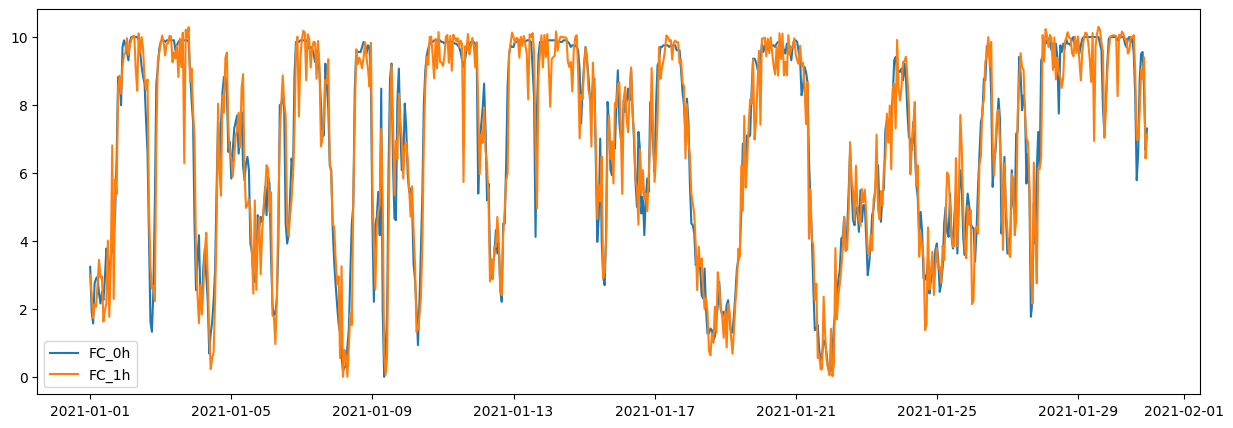

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(data['FC_0h'], label='FC_0h')
plt.plot(data['FC_1h'], label='FC_1h')
plt.legend()
plt.show()

In [16]:
import gurobipy as gp
from gurobipy import GRB

In [17]:
def objective(t, p_adj, data):
    s = 0
    for i in range(24):
        s += data['DW'].iloc[i] * (data['FC_{i}h'.format(i=i)].iloc[t] - data['forward bid'].iloc[t + i] - p_adj[i]) - \
             data['UP'].iloc[i] * (data['forward bid'].iloc[t + i] + p_adj[i] - data['FC_{i}h'.format(i=i)].iloc[
            t]) + lambda_H * rho_H * p_adj[i]
    return s

In [18]:
t = 0

m = gp.Model('Real Time Adjustment')

# Variables
p_adj = m.addMVar((24,), vtype=GRB.CONTINUOUS, name='p_adj', lb=0.0, ub=P_H)

# Objective
m.setObjective(objective(t, p_adj, data), GRB.MAXIMIZE)

# Constraints
m.addConstr(p_adj.sum() <= H / rho_H, 'H')

for i in range(24):
    m.addConstr(p_adj[i] <= max(0, data['FC_{i}h'.format(i=i)].iloc[t] - data['forward bid'].iloc[t + i]),
                'P_{i}'.format(i=i))

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-27
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 25 rows, 24 columns and 48 nonzeros
Model fingerprint: 0xfbf113a0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 4e+01]
  Bounds range     [5e-01, 5e-01]
  RHS range        [3e+00, 2e+01]
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1010087e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.101008725e+03


In [19]:
m.getVars()

[<gurobi.Var p_adj[0] (value 0.0)>,
 <gurobi.Var p_adj[1] (value 0.0)>,
 <gurobi.Var p_adj[2] (value 0.0)>,
 <gurobi.Var p_adj[3] (value 0.0)>,
 <gurobi.Var p_adj[4] (value 0.0)>,
 <gurobi.Var p_adj[5] (value 0.0)>,
 <gurobi.Var p_adj[6] (value 0.0)>,
 <gurobi.Var p_adj[7] (value 0.0)>,
 <gurobi.Var p_adj[8] (value 0.0)>,
 <gurobi.Var p_adj[9] (value 0.0)>,
 <gurobi.Var p_adj[10] (value 0.0)>,
 <gurobi.Var p_adj[11] (value 0.0)>,
 <gurobi.Var p_adj[12] (value 0.0)>,
 <gurobi.Var p_adj[13] (value 0.0)>,
 <gurobi.Var p_adj[14] (value 0.0)>,
 <gurobi.Var p_adj[15] (value 0.0)>,
 <gurobi.Var p_adj[16] (value 0.0)>,
 <gurobi.Var p_adj[17] (value 0.0)>,
 <gurobi.Var p_adj[18] (value 0.0)>,
 <gurobi.Var p_adj[19] (value 0.0)>,
 <gurobi.Var p_adj[20] (value 0.0)>,
 <gurobi.Var p_adj[21] (value 0.5)>,
 <gurobi.Var p_adj[22] (value 0.5)>,
 <gurobi.Var p_adj[23] (value 0.5)>]

## HAPD-AF-12

In [20]:
df_hapd_af_12 = pd.read_csv("./results/2020/HAPD-AF-12.csv")

result_hapd_af_12 = test_price_domain(df_hapd_af_12, idx_start, idx_end)
print(f"HAPD-AF-12: {np.sum(result_hapd_af_12['obj'])}")

HAPD-AF-12: 1822643.46930457


In [21]:
print(result_hapd_af_12['forward_bid'])
print(result_hapd_af_12['h_prod'])

df_hapd_af_12 = pd.concat([pd.Series(result_hapd_af_12['forward_bid']), pd.Series(result_hapd_af_12['h_prod'])], axis=1)
df_hapd_af_12.columns = ['forward bid', 'h prod']
display(df_hapd_af_12)

[-4.451999664767008, -6.9484522662955905, -5.197990231440457, -6.077528941454848, -2.3767869845841503, -3.073510574114014, -3.1665267438404285, -2.4968089435722725, -3.1705474606944914, -4.086831177851562, -3.532319879597803, -2.5557050542731243, -2.3188931921673017, -2.5912630176018885, -3.055896011922421, -4.411541253022165, -3.3265187873315716, -2.373935932163736, -3.749674632406851, -5.796330691457815, -6.229799138406465, -7.404556873342507, -6.176124370440428, -7.700820489483326, -7.350363933605922, -7.738513293219237, -8.272388452027528, -8.428586528744194, -7.854389431666323, -7.3290023842432355, -5.1689643234974385, 3.492600428078577, 3.162520216703659, 1.815318765962481, 0.5523911606890084, 2.677816239265098, 4.067711482531825, 2.504406553248573, 3.1816871743746904, 6.726832732774653, 2.7251556314294527, 7.399766852409431, 5.72076132851293, 9.219655900038362, 7.587134699360086, -2.3600993782005197, 0.14445584402347222, -0.33270794360375966, -2.43992592469277, -1.85290026823023

,forward bid,h prod
0,-4.452000,10.0
1,-6.948452,10.0
2,-5.197990,10.0
3,-6.077529,10.0
4,-2.376787,10.0
...,...,...
8755,8.661305,0.0
8756,9.628954,0.0
8757,8.275977,0.0
8758,-2.368340,10.0


In [22]:
data = pd.concat([df, prices, forecasts], axis=1)
data = data.rename({'production_RE': 'FC_0h'}, axis=1)
display(data)

,forward bid,hydrogen production,forward_RE,UP,DW,FC_0h,FC_1h,FC_2h,FC_3h,FC_4h,...,FC_15h,FC_16h,FC_17h,FC_18h,FC_19h,FC_20h,FC_21h,FC_22h,FC_23h,FC_24h
2021-01-01 00:00:00,6.735217,0.0,30.78,30.78,20.00,3.235294,2.992904,2.296337,1.930483,2.292906,...,2.394894,6.187304,3.527442,5.343550,5.862827,8.086749,8.542651,8.182789,9.177086,9.165245
2021-01-01 01:00:00,-7.229688,10.0,30.64,30.64,20.00,1.911765,2.423068,1.988212,2.339120,1.876458,...,6.187638,3.527663,5.343697,5.862924,8.086813,8.542694,8.182818,9.177105,9.165257,9.199129
2021-01-01 02:00:00,-3.560665,10.0,30.43,30.43,20.00,1.568627,1.720883,2.217345,1.778974,2.138537,...,3.526957,5.343229,5.862615,8.086608,8.542558,8.182728,9.177046,9.165218,9.199103,9.654737
2021-01-01 03:00:00,5.994885,0.0,28.79,28.79,23.00,2.745098,2.137740,1.742712,2.109509,3.000126,...,5.343019,5.862475,8.086516,8.542497,8.182687,9.177019,9.165200,9.199091,9.654729,9.481359
2021-01-01 04:00:00,-1.089615,10.0,28.42,28.42,22.73,2.892157,2.060262,2.254160,3.115924,3.215586,...,5.863314,8.087071,8.542865,8.182931,9.177180,9.165307,9.199162,9.654776,9.481390,9.787416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-30 19:00:00,-1.612456,10.0,19.58,20.67,19.58,9.509804,9.041430,8.518451,8.871527,6.679837,...,7.669414,8.606327,8.183193,7.515521,6.995691,6.044070,7.355496,8.788237,9.461627,9.520010
2021-01-30 20:00:00,0.000000,10.0,19.09,19.09,19.09,9.558824,8.763335,8.983077,6.769136,7.093161,...,8.606974,8.183621,7.515804,6.995879,6.044195,7.355579,8.788292,9.461663,9.520034,9.805577
2021-01-30 21:00:00,0.000000,10.0,18.71,18.71,18.71,8.382353,9.398989,6.958594,7.244828,7.216688,...,8.184720,7.516532,6.996361,6.044514,7.355790,8.788432,9.461755,9.520095,9.805617,9.939807
2021-01-30 22:00:00,0.000000,10.0,18.30,18.30,18.30,6.666667,6.427058,7.002700,7.022858,8.608162,...,7.515128,6.995431,6.043898,7.355382,8.788162,9.461577,9.519976,9.805539,9.939755,10.002839
